# Gaussian processes

In [1]:
from itertools import islice

# import bokeh.io
# import bokeh.plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

from IPython.core.display import HTML

## Long term forecasting

### Data preprocessing

1. Load dataset with CO2 particles density in ManuaLoa observation center between 1958 and 2021. Select columns with date and ppm (concentration).
2. Remove rows with missing `ppm` values and any `NaN` values.
3. Visualize the data, creating `ppm` plot for all years.
4. Divide data as training and test (test data from 2012).

In [5]:
df = pd.read_csv(
    "datasets/monthly_in_situ_co2_mlo2.csv", 
    usecols=[3, 4],
    na_values='-99.99',
    dtype=np.float64
)

# drop missing values
df.dropna(inplace=True)

# remove whitespace from column names
df.rename(columns=lambda x: x.strip(), inplace=True)

In [6]:
df

,Date,CO2
2,1958.2027,315.70
3,1958.2877,317.45
4,1958.3699,317.51
6,1958.5370,315.86
7,1958.6219,314.93
...,...,...
763,2021.6219,414.34
764,2021.7068,412.90
765,2021.7890,413.55
766,2021.8740,414.82


In [4]:
fig = bokeh.plotting.figure(width=600, height=300, x_range=(1958, 2021), y_range=(310, 420))
fig.xaxis.axis_label = "Date"
fig.yaxis.axis_label = "CO2"
fig.add_layout(bokeh.models.Title(text="CO2 measurements over time", text_font_size="14pt"), 'above')
fig.line(df["Date"], df["CO2"],line_width=2, line_color="blue")
fig.toolbar.autohide = True
bokeh.io.output_notebook(hide_banner=True)
bokeh.plotting.show(fig)

In [7]:
df_train = df[df["Date"] < 2012]
df_test = df[df["Date"] >= 2012]

### Gaussian process training

1. Define mean value function as constant function defined as average measurement value in training set (`tensorflow.constant`).
2. Define parametrized composite covariance (kernel) function that is a sum of:
    - Exponential Quadratic kernel (tfp.ExponentiatedQuadratic)
    - Local Periodic kernel (multiplication of tfp.ExpSinSquared and tfp.ExponentiatedQuadratic)
    - RationalQuadratic kernel (tfp.RationalQuadratic)
    - White Noise kernel
3. Define negative log likelihood function with arguments training set samples, complex covariance function and mean value function (`tfp.GaussianProcess`).
4. Initialize and run the Adam optimizer (`tf.keras.optimizers.Adam`): `learning_rate=0.001, batch_size=128, nb_iterations=10001` to minimize NLL function.
5. After training plot how did the NLL value change in all iterations.
6. Print table with learned parameters values.

**Kernel definitions**

In [6]:
def get_kernel(df_train: pd.DataFrame, val_col: str):
    observations_mean = tf.constant([np.mean(df_train[val_col].values)], dtype=tf.float64)
    mean_fn = lambda _: observations_mean
    
    constrain_positive = tfp.bijectors.Shift(np.finfo(np.float64).tiny)(tfp.bijectors.Exp())

    smooth_amplitude = tfp.util.TransformedVariable(
        initial_value=10., bijector=constrain_positive, dtype=np.float64,
        name='smooth_amplitude')
    smooth_length_scale = tfp.util.TransformedVariable(
        initial_value=10., bijector=constrain_positive, dtype=np.float64,
        name='smooth_length_scale')

    smooth_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
        amplitude=smooth_amplitude, 
        length_scale=smooth_length_scale
    )
    
    periodic_amplitude = tfp.util.TransformedVariable(
        initial_value=5.0, bijector=constrain_positive, dtype=np.float64,
        name='periodic_amplitude')
    periodic_length_scale = tfp.util.TransformedVariable(
        initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
        name='periodic_length_scale')
    periodic_period = tfp.util.TransformedVariable(
        initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
        name='periodic_period')
    periodic_local_length_scale = tfp.util.TransformedVariable(
        initial_value=1.0, bijector=constrain_positive, dtype=np.float64,
        name='periodic_local_length_scale')

    local_periodic_kernel = (
        tfp.math.psd_kernels.ExpSinSquared(
            amplitude=periodic_amplitude, 
            length_scale=periodic_length_scale,
            period=periodic_period) * 
        tfp.math.psd_kernels.ExponentiatedQuadratic(
            length_scale=periodic_local_length_scale)
    )
    
    irregular_amplitude = tfp.util.TransformedVariable(
        initial_value=1., bijector=constrain_positive, dtype=np.float64,
        name='irregular_amplitude')
    irregular_length_scale = tfp.util.TransformedVariable(
        initial_value=1., bijector=constrain_positive, dtype=np.float64,
        name='irregular_length_scale')
    irregular_scale_mixture = tfp.util.TransformedVariable(
        initial_value=1., bijector=constrain_positive, dtype=np.float64,
        name='irregular_scale_mixture')

    irregular_kernel = tfp.math.psd_kernels.RationalQuadratic(
        amplitude=irregular_amplitude,
        length_scale=irregular_length_scale,
        scale_mixture_rate=irregular_scale_mixture
    )
    
    observation_noise_variance = tfp.util.TransformedVariable(
        initial_value=1, bijector=constrain_positive, dtype=np.float64,
        name='observation_noise_variance'
    )
    
    kernel = (smooth_kernel + local_periodic_kernel + irregular_kernel)
    
    observation_noise_variance = tfp.util.TransformedVariable(
        initial_value=1, bijector=constrain_positive, dtype=np.float64,
        name='observation_noise_variance'
    )
    
    trainable_variables = [v.variables[0] for v in [
        smooth_amplitude,
        smooth_length_scale,
        periodic_amplitude,
        periodic_length_scale,
        periodic_period,
        periodic_local_length_scale,
        irregular_amplitude,
        irregular_length_scale,
        irregular_scale_mixture,
        observation_noise_variance
    ]]
    
    return kernel, mean_fn, observation_noise_variance, trainable_variables

**Optimization**

In [7]:
batched_dataset = (
    tf.data.Dataset.from_tensor_slices((df_train["Date"].values.reshape(-1, 1), df_train["CO2"].values))
    .shuffle(buffer_size=len(df))
    .repeat(count=None)
    .batch(128)
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

kernel, mean_fn, observation_noise_variance, trainable_variables = get_kernel(df_train, val_col="CO2")


@tf.function(autograph=False, experimental_compile=False)
def gp_loss_fn(index_points, observations):
    """
    Gaussian process negative-log-likelihood loss function.
    """
    gp = tfp.distributions.GaussianProcess(
        mean_fn=mean_fn,
        kernel=kernel,
        index_points=index_points,
        observation_noise_variance=observation_noise_variance
    )
    
    negative_log_likelihood = -gp.log_prob(observations)
    return negative_log_likelihood


batch_nlls = []
full_ll = []
nb_iterations = 10001
for i, (index_points_batch, observations_batch) in tqdm(
    enumerate(islice(batched_dataset, nb_iterations)), 
    total=nb_iterations
):
    with tf.GradientTape() as tape:
        loss = gp_loss_fn(index_points_batch, observations_batch)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    batch_nlls.append((i, loss.numpy()))
    if i % 100 == 0:
        ll = gp_loss_fn(
            index_points=df_train["Date"].values.reshape(-1, 1),
            observations=df_train["CO2"].values
        )
        full_ll.append((i, ll.numpy()))



  0%|                                                                                                                                                                                   | 0/10001 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [03:22<00:00, 49.44it/s]


In [8]:
fig = bokeh.plotting.figure(width=600, height=350, x_range=(0, nb_iterations), y_range=(50, 200))
fig.add_layout(bokeh.models.Title(text="Training NLL", text_font_size="14pt"), 'above')
fig.xaxis.axis_label = "iter"
fig.yaxis.axis_label = "NLL batch"

fig.line(*zip(*batch_nlls), legend_label="Batch", line_width=2, line_color='blue')

fig.extra_y_ranges = {'fig1ax2': bokeh.models.Range1d(start=130, end=250)}
fig.line(*zip(*full_ll), legend_label="All data",line_width=2, line_color='red', y_range_name='fig1ax2')
fig.add_layout(bokeh.models.LinearAxis(y_range_name='fig1ax2', axis_label="NLL all"), 'right')

fig.legend.location = 'top_right'
fig.toolbar.autohide = True
bokeh.plotting.show(fig)

In [18]:
data = list([(var.name[:-2], var.numpy()) for var in trainable_variables])
df_variables = pd.DataFrame( data, columns=["Parameter", "Value"])
display(HTML(df_variables.to_html(index=False, float_format=lambda x: f'{x:.4f}')))

Parameter,Value
smooth_amplitude,4.8433
smooth_length_scale,4.5986
periodic_amplitude,1.1206
periodic_length_scale,0.5068
periodic_period,-0.0003
periodic_local_length_scale,4.7410
irregular_amplitude,0.0147
irregular_length_scale,0.3180
irregular_scale_mixture,-2.2981
observation_noise_variance,-2.9381


### Gaussian process prediction

1. Using learned kernel function parameters and calculated average value function, create posterior regression model to perform predictions for test set (`tfp.GaussianProcessRegressionModel`).
2. For test set plot prediction of CO2 concentration starting from 2012. Plot 2 standard deviations as prediction uncertainty.
3. Comment the results. In low long horizon do the results fit in uncertainty +- 2 stddev? What trend do you observe for prediction and real values in about 2016?

In [19]:
gp_posterior_predict = tfp.distributions.GaussianProcessRegressionModel(
    mean_fn=mean_fn,
    kernel=kernel,
    index_points=df_test["Date"].values.reshape(-1, 1),
    observation_index_points=df_train["Date"].values.reshape(-1, 1),
    observations=df_train["CO2"].values,
    observation_noise_variance=observation_noise_variance
)

posterior_mean_predict = gp_posterior_predict.mean()
posterior_std_predict = gp_posterior_predict.stddev()

In [20]:
mu = posterior_mean_predict.numpy()
sigma = posterior_std_predict.numpy()

fig = bokeh.plotting.figure(
    width=600, height=400,
    x_range=(2012, 2021.3), y_range=(384, 418))
fig.xaxis.axis_label = 'Date'
fig.yaxis.axis_label = 'CO₂ (ppm)'
fig.add_layout(bokeh.models.Title(
    text='Posterior predictions conditioned on observations before 2012.',
    text_font_style="italic"), 'above')
fig.add_layout(bokeh.models.Title(
    text='Atmospheric CO₂ concentrations', 
    text_font_size="14pt"), 'above')
fig.circle(
    df["Date"], df["CO2"], legend_label='True data',
    size=2, line_color='midnightblue')
fig.line(
    df_test["Date"].values, mu, legend_label='μ (predictions)',
    line_width=2, line_color='firebrick')

band_x = np.append(df_test["Date"].values, df_test["Date"].values[::-1])
band_y = np.append((mu + 2*sigma), (mu - 2*sigma)[::-1])
fig.patch(
    band_x, band_y, color='firebrick', alpha=0.4, 
    line_color='firebrick', legend_label='2σ')

fig.legend.location = 'top_left'
fig.toolbar.autohide = True
bokeh.plotting.show(fig)

Predictions fit int he range of two standard deviations up to 2016. Since that year predictions start to get too small, since the trend in the data gets higher much faster, which was not seen before in the training data.

## Short term forecasting

1. Using WIG20 data and CD Projekt data perform similar experiment as before, forecasting the stocks in the horizon of 7 and 14 days. For each dataset select 2 different points for train-test cut-off: one in 2019 and one in 2020. Visualize the results. Comment on quality of prediction.
2. How can we prevent overfitting while optimizing the covariance function parameters on train set? Propose and implement a solution.
3. How does the NRMSE error change for 7 day horizon while moving the train-test cut-off point 10 times by 7 days?
4. Compare the results with Facebook Prophet model results.

In [105]:
df_wig20 = pd.read_csv("wig20_d.csv", parse_dates=["Data"])
df_cdpr = pd.read_csv("cdr_d.csv", parse_dates=["Data"])

mask_2019 = df_wig20["Data"] < "2019-06-01"
mask_2020 = df_wig20["Data"] < "2020-02-20"

df_wig20_2019_train = df_wig20.loc[mask_2019, ["Data", "Najwyzszy"]]
df_wig20_2019_test = df_wig20.loc[~mask_2019, ["Data", "Najwyzszy"]]

df_wig20_2020_train = df_wig20.loc[mask_2020, ["Data", "Najwyzszy"]]
df_wig20_2020_test = df_wig20.loc[~mask_2020, ["Data", "Najwyzszy"]]

mask_2019 = df_cdpr["Data"] < "2019-06-01"
mask_2020 = df_cdpr["Data"] < "2020-02-20"

df_cdpr_2019_train = df_cdpr.loc[mask_2019, ["Data", "Najwyzszy"]]
df_cdpr_2019_test = df_cdpr.loc[~mask_2019, ["Data", "Najwyzszy"]]

df_cdpr_2020_train = df_cdpr.loc[mask_2020, ["Data", "Najwyzszy"]]
df_cdpr_2020_test = df_cdpr.loc[~mask_2020, ["Data", "Najwyzszy"]]

df_wig20["Data"] = df_wig20["Data"].dt.year + df_wig20["Data"].dt.dayofyear / 365
df_cdpr["Data"] = df_cdpr["Data"].dt.year + df_cdpr["Data"].dt.dayofyear / 365

df_wig20_2019_train["Data"] = df_wig20_2019_train["Data"].dt.year + df_wig20_2019_train["Data"].dt.dayofyear / 365
df_wig20_2019_test["Data"] = df_wig20_2019_test["Data"].dt.year + df_wig20_2019_test["Data"].dt.dayofyear / 365

df_wig20_2020_train["Data"] = df_wig20_2020_train["Data"].dt.year + df_wig20_2020_train["Data"].dt.dayofyear / 365
df_wig20_2020_test["Data"] = df_wig20_2020_test["Data"].dt.year + df_wig20_2020_test["Data"].dt.dayofyear / 365

df_cdpr_2019_train["Data"] = df_cdpr_2019_train["Data"].dt.year + df_cdpr_2019_train["Data"].dt.dayofyear / 365
df_cdpr_2019_test["Data"] = df_cdpr_2019_test["Data"].dt.year + df_cdpr_2019_test["Data"].dt.dayofyear / 365

df_cdpr_2020_train["Data"] = df_cdpr_2020_train["Data"].dt.year + df_cdpr_2020_train["Data"].dt.dayofyear / 365
df_cdpr_2020_test["Data"] = df_cdpr_2020_test["Data"].dt.year + df_cdpr_2020_test["Data"].dt.dayofyear / 365

In [84]:
def train(df_train: pd.DataFrame):
    batched_dataset = (
        tf.data.Dataset.from_tensor_slices((df_train["Data"].values.reshape(-1, 1), df_train["Najwyzszy"].values))
        .shuffle(buffer_size=len(df))
        .repeat(count=None)
        .batch(128)
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    kernel, mean_fn, observation_noise_variance, trainable_variables = get_kernel(df_train, val_col="Najwyzszy")


    @tf.function(autograph=False, experimental_compile=False)
    def gp_loss_fn(index_points, observations):
        """
        Gaussian process negative-log-likelihood loss function.
        """
        gp = tfp.distributions.GaussianProcess(
            mean_fn=mean_fn,
            kernel=kernel,
            index_points=index_points,
            observation_noise_variance=observation_noise_variance
        )

        negative_log_likelihood = -gp.log_prob(observations)
        return negative_log_likelihood

    nb_iterations = 10001
    for i, (index_points_batch, observations_batch) in tqdm(
        enumerate(islice(batched_dataset, nb_iterations)), 
        total=nb_iterations
    ):
        with tf.GradientTape() as tape:
            loss = gp_loss_fn(index_points_batch, observations_batch)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
        batch_nlls.append((i, loss.numpy()))
    
    return mean_fn, kernel, observation_noise_variance


def predict(df_train, df_test, mean_fn, kernel, observation_noise_variance):    
    gp_posterior_predict = tfp.distributions.GaussianProcessRegressionModel(
        mean_fn=mean_fn,
        kernel=kernel,
        index_points=df_test["Data"].values.reshape(-1, 1),
        observation_index_points=df_train["Data"].values.reshape(-1, 1),
        observations=df_train["Najwyzszy"].values,
        observation_noise_variance=observation_noise_variance
    )

    posterior_mean_predict = gp_posterior_predict.mean().numpy()
    posterior_std_predict = gp_posterior_predict.stddev().numpy()
    
    return posterior_mean_predict, posterior_std_predict


def plot(df, df_train, df_test, title, mu, sigma):
    fig = bokeh.plotting.figure(width=600, height=400)
    fig.xaxis.axis_label = 'Date'
    fig.yaxis.axis_label = 'Stock value'
    fig.add_layout(bokeh.models.Title(text=title, text_font_size="14pt"), 'above')
    fig.circle(df["Data"], df["Najwyzszy"], legend_label='True data', size=2, line_color='midnightblue')
    fig.line(df_test["Data"], mu, legend_label='μ (predictions)', line_width=2, line_color='firebrick')

    band_x = np.append(df_test["Data"].values, df_test["Data"].values[::-1])
    band_y = np.append((mu + 2*sigma), (mu - 2*sigma)[::-1])
    fig.patch(
        band_x, band_y, color='firebrick', alpha=0.4, 
        line_color='firebrick', legend_label='2σ'
    )

    fig.legend.location = 'top_left'
    fig.toolbar.autohide = False
    bokeh.plotting.show(fig)


In [86]:
df = df_wig20
df_train = df_wig20_2019_train
df_test = df_wig20_2019_test

mean_fn, kernel, observation_noise_variance = train(df_train)
mu, sigma = predict(df_train, df_test, mean_fn, kernel, observation_noise_variance)
plot(df, df_train, df_test, "WIG20 for 2019", mu, sigma)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [02:31<00:00, 66.23it/s]


In [87]:
df = df_wig20
df_train = df_wig20_2020_train
df_test = df_wig20_2020_test

mean_fn, kernel, observation_noise_variance = train(df_train)
mu, sigma = predict(df_train, df_test, mean_fn, kernel, observation_noise_variance)
plot(df, df_train, df_test, "WIG20 for 2020", mu, sigma)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [02:30<00:00, 66.60it/s]


In [111]:
df = df_cdpr
df_train = df_cdpr_2019_train
df_test = df_cdpr_2019_test

mean_fn, kernel, observation_noise_variance = train(df_train)
mu, sigma = predict(df_train, df_test, mean_fn, kernel, observation_noise_variance)
plot(df, df_train, df_test, "CDPR for 2019", mu, sigma)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [02:32<00:00, 65.57it/s]


In [112]:
df = df_cdpr
df_train = df_cdpr_2020_train
df_test = df_cdpr_2020_test

mean_fn, kernel, observation_noise_variance = train(df_train)
mu, sigma = predict(df_train, df_test, mean_fn, kernel, observation_noise_variance)
plot(df, df_train, df_test, "CDPR for 2020", mu, sigma)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [02:25<00:00, 68.67it/s]


Prediction is not really precise. Even for 7 and 14 days of prediction the standard deviations get incredibly high very fast. This makes sense, since if the the random walk hypothesis is true, it is even straight up impossible to predict those values as the changes are just a random walk. We are dealing with technical analysis, i.e. use only shape of stock values, so this makes this even more probable.

Predictions are really bad for WIG20 for 2019, but moderately good for WIG20 for 2020, since trend for forecasting period was particularly simple. CDPR for 2019 is quite interesting, as Gaussian process was fooled with minor fluctuations and quite ignored the great increasing trend, which became even more apparent later.

For CDPR 2020 it shows the opposite behavior - it managed to catch this trend and ignored the fluctuations. Tt should be noted, however, that this only makes sense for longer term prediction - for 7 and 14 days it is harmful, as CDPR had short decreasing period then. Additionally the standard deviations became lower for 2020.

I lacked time to perform points 2 and 3.

## Prophet

In [115]:
from prophet import Prophet

In [119]:
df_wig20

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1991-04-16,100.00,100.00,100.00,100.00,325
1,1991-04-23,95.70,95.70,95.70,95.70,5905
2,1991-04-30,93.50,93.50,93.50,93.50,7162
3,1991-05-14,92.90,92.90,92.90,92.90,18300
4,1991-05-21,95.50,95.50,95.50,95.50,14750
...,...,...,...,...,...,...
6963,2020-12-04,1894.40,1952.28,1894.35,1947.68,28408098
6964,2020-12-07,1949.61,1965.92,1926.87,1958.53,32118759
6965,2020-12-08,1941.14,1970.27,1933.68,1970.27,33485126
6966,2020-12-09,1976.65,2023.91,1976.65,1994.12,57962389


In [120]:
df_wig20 = pd.read_csv("wig20_d.csv", parse_dates=["Data"])
df_cdpr = pd.read_csv("cdr_d.csv", parse_dates=["Data"])

df_wig20 = df_wig20[["Data", "Najwyzszy"]]
df_cdpr = df_cdpr[["Data", "Najwyzszy"]]

df_wig20.columns = ["ds", "y"]
df_cdpr.columns = ["ds", "y"]

mask_2019 = df_wig20["ds"] < "2019-06-01"
mask_2020 = df_wig20["ds"] < "2020-02-20"

df_wig20_2019_train = df_wig20.loc[mask_2019, ["ds", "y"]]
df_wig20_2019_test = df_wig20.loc[~mask_2019, ["ds", "y"]]

df_wig20_2020_train = df_wig20.loc[mask_2020, ["ds", "y"]]
df_wig20_2020_test = df_wig20.loc[~mask_2020, ["ds", "y"]]

mask_2019 = df_cdpr["ds"] < "2019-06-01"
mask_2020 = df_cdpr["ds"] < "2020-02-20"

df_cdpr_2019_train = df_cdpr.loc[mask_2019, ["ds", "y"]]
df_cdpr_2019_test = df_cdpr.loc[~mask_2019, ["ds", "y"]]

df_cdpr_2020_train = df_cdpr.loc[mask_2020, ["ds", "y"]]
df_cdpr_2020_test = df_cdpr.loc[~mask_2020, ["ds", "y"]]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


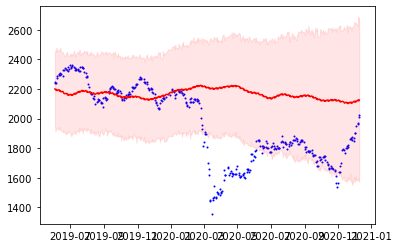

In [144]:
estimator = Prophet()
estimator.fit(df_wig20_2019_train)

forecast = estimator.predict(df_wig20_2019_test)
forecast = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

test_forecast = df_wig20_2019_test.merge(forecast)  # ds, y, yhat, yhat_lower, yhat_upper

fig, ax = plt.subplots()
ax.scatter(test_forecast["ds"], test_forecast["y"], color="b", s=1)
ax.plot(test_forecast["ds"], test_forecast["yhat"], color="r")
ax.fill_between(test_forecast["ds"], test_forecast["yhat_lower"], test_forecast["yhat_upper"], color='r', alpha=.1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


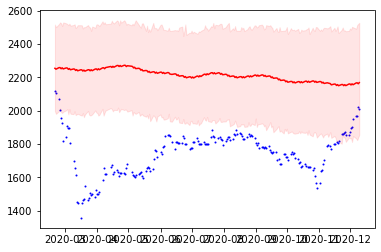

In [145]:
estimator = Prophet()
estimator.fit(df_wig20_2020_train)

forecast = estimator.predict(df_wig20_2020_test)
forecast = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

test_forecast = df_wig20_2020_test.merge(forecast)  # ds, y, yhat, yhat_lower, yhat_upper

fig, ax = plt.subplots()
ax.scatter(test_forecast["ds"], test_forecast["y"], color="b", s=1)
ax.plot(test_forecast["ds"], test_forecast["yhat"], color="r")
ax.fill_between(test_forecast["ds"], test_forecast["yhat_lower"], test_forecast["yhat_upper"], color='r', alpha=.1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


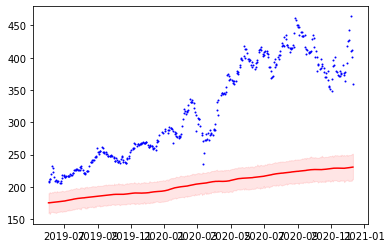

In [146]:
estimator = Prophet()
estimator.fit(df_cdpr_2019_train)

forecast = estimator.predict(df_cdpr_2019_test)
forecast = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

test_forecast = df_cdpr_2019_test.merge(forecast)  # ds, y, yhat, yhat_lower, yhat_upper

fig, ax = plt.subplots()
ax.scatter(test_forecast["ds"], test_forecast["y"], color="b", s=1)
ax.plot(test_forecast["ds"], test_forecast["yhat"], color="r")
ax.fill_between(test_forecast["ds"], test_forecast["yhat_lower"], test_forecast["yhat_upper"], color='r', alpha=.1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


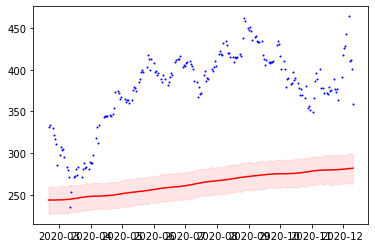

In [147]:
estimator = Prophet()
estimator.fit(df_cdpr_2020_train)

forecast = estimator.predict(df_cdpr_2020_test)
forecast = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

test_forecast = df_cdpr_2020_test.merge(forecast)  # ds, y, yhat, yhat_lower, yhat_upper

fig, ax = plt.subplots()
ax.scatter(test_forecast["ds"], test_forecast["y"], color="b", s=1)
ax.plot(test_forecast["ds"], test_forecast["yhat"], color="r")
ax.fill_between(test_forecast["ds"], test_forecast["yhat_lower"], test_forecast["yhat_upper"], color='r', alpha=.1)

Prophet model was made to incorporate various seasonalities and it shows. For quasi-random data like stock values it just does not work. The data does not meet the assumptions of hierarchical Bayesian model of Prophet, so the best it can do is to predict the trend component.